This notebook is for training the RESNET model. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os 
import sys 
from pathlib import Path

In [4]:
from fastai.vision import *

## Set working directory when running locally

In [5]:
os.chdir('../')

In [6]:
os.getcwd()

'/Users/christinebalili/Desktop/coralai'

## (Optional) Getting data from Google Cloud
Run this cell when this notebooks ran in Google colab.

In [0]:
from google.colab import auth
auth.authenticate_user()

project_id = 'coralai'

# Create the service client.
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

from apiclient.http import MediaIoBaseDownload
def download_from_GCS(filename, bucket_name, path_to_download):
  
  if not os.path.exists('data'):
    os.makedirs('data')
  
  with open(os.path.join('data', filename), 'wb') as f:
    
    # Download the file from a given Google Cloud Storage bucket.
    request = gcs_service.objects().get_media(bucket=bucket_name,
                                              object=path_to_download)
    media = MediaIoBaseDownload(f, request)
    done = False
    
    while not done:
      # _ is a placeholder for a progress object that we ignore.
      # (Our file is small, so we skip reporting progress.)
      _, done = media.next_chunk()        

  print('Download complete')
  
download_from_GCS('train.zip', 'coralai', 'coralAI/data/train.zip')
download_from_GCS('validation.zip', 'coralai', 'coralAI/data/validation.zip')
download_from_GCS('test.zip', 'coralai', 'coralAI/data/test.zip')

In [0]:
# Run this cell in colab setting 
!unzip data/train.zip
!rm data/train.zip

!unzip data/test.zip
!rm data/test.zip

!unzip data/validation.zip
!rm data/validation.zip

!mv image_patches data/train
!mv test data/test
!mv validation data/validation

## Loading of Data
This assumes that data is stored in 'data' directory.

In [7]:
p = Path('data')
list_of_paths = [x for x in p.iterdir() if x.is_dir()]

In [8]:
list_of_paths

[PosixPath('data/test'),
 PosixPath('data/models'),
 PosixPath('data/train'),
 PosixPath('data/validation')]

In [9]:
il = ImageItemList.from_folder(p, convert_mode='RGB')

In [10]:
il.items[0]

PosixPath('data/test/61/PR_20121129_005853_940_LC16_503_261.png')

In [11]:
il

ImageItemList (329711 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data

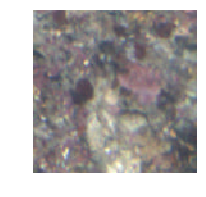

In [12]:
il[506].show()

In [13]:
sd = il.split_by_folder(train='train', valid='validation')

In [14]:
sd

ItemLists;

Train: ImageItemList (229670 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 115, 128)
Path: data;

Valid: ImageItemList (50858 items)
Image (3, 128, 128),Image (3, 89, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: data;

Test: None

## Generate Label List

In [15]:
ll = sd.label_from_folder()

/anaconda3/lib/python3.6/site-packages/fastai/data_block.py:487: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
72, 12, 93, 102
  if getattr(ds, 'warn', False): warn(ds.warn)


In [16]:
ll

LabelLists;

Train: LabelList (229670 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 115, 128)
y: CategoryList
61,61,61,61,61
Path: data;

Valid: LabelList (50854 items)
x: ImageItemList
Image (3, 128, 128),Image (3, 89, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
61,61,61,61,61
Path: data;

Test: None

In [17]:
x, y = ll.train[0]

61 torch.Size([3, 128, 128])


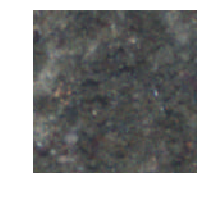

In [18]:
x.show()
print(y, x.shape)

## Image Pre-processing 
Not working

In [19]:
bs = 128
tfms = get_transforms()

ll = ll.transform(tfms=tfms, size=128).databunch(bs=bs, num_workers=4).normalize()

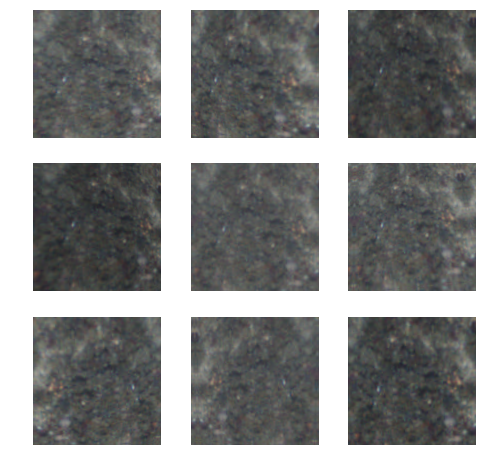

In [20]:
def _plot(i,j,ax): ll.train_ds[0][0].show(ax)
plot_multi(_plot, 3, 3, figsize=(8,8))

In [22]:
ll.export()

In [21]:
# Not working as of the moment due to inefficiency in shared memory
ll.show_batch(rows=3, figsize=(5,5))

RuntimeError: DataLoader worker (pid 83703) is killed by signal: Unknown signal: 0. 

In [26]:
learn = create_cnn(ll, models.resnet18, metrics=KappaScore())
learn.fit(1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 89759658.99it/s]


epoch,train_loss,valid_loss,kappa_score
1,1.133060,1.033754,0.646885


In [0]:
learn.save('one_epoch_test')

In [33]:
!ls data/models

one_epoch_test.pkl.pth	one_epoch_test.pth


In [34]:
!gsutil cp data/models/one_epoch_test.pth gs://coralai/coralAI/data/models/one_epoch_test.pth

Copying file://data/models/one_epoch_test.pth [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/49.6 MiB.                                     


In [35]:
learn.fit(10)

epoch,train_loss,valid_loss,kappa_score
1,1.058900,0.950196,0.667583
2,0.994741,0.908560,0.683124
3,0.965148,0.888521,0.687948
4,0.968962,0.882133,0.691236
5,0.949844,0.861987,0.697673
6,0.950703,0.859963,0.699676
7,0.932611,0.855653,0.697562
8,0.910840,0.853574,0.700041
9,0.929339,0.834481,0.706257
10,0.916471,0.835902,0.705353


In [0]:
learn.save('ten_epochs_test')

In [37]:
!gsutil cp data/models/ten_epochs_test.pth gs://coralai/coralAI/data/models/ten_epochs_test.pth

Copying file://data/models/ten_epochs_test.pth [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/49.6 MiB.                                     


In [0]:
#Save data bunch
ll.save('benthoz_data.databunch')

In [39]:
!gsutil cp data/benthoz_data.databunch gs://coralai/coralAI/data/benthoz_data.databunch

Copying file://data/benthoz_data.databunch [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/21.8 MiB.                                     


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

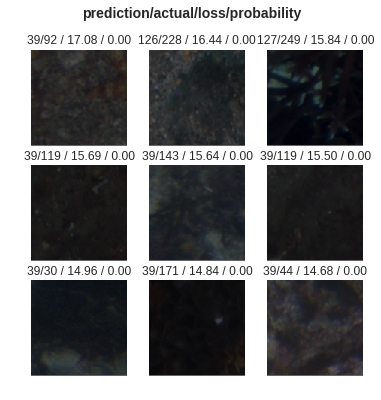

In [41]:
interp.plot_top_losses(9, figsize=(6,6))

In [0]:
confusion_matrix = interp.confusion_matrix()
confusion_matrix_df = pd.DataFrame(confusion_matrix)
confusion_matrix_df.to_csv('data/confusion_matrix.csv')

In [43]:
!gsutil cp data/confusion_matrix.csv gs://coralai/coralAI/data/confusion_matrix.csv

Copying file://data/confusion_matrix.csv [Content-Type=text/csv]...
/ [1 files][ 37.7 KiB/ 37.7 KiB]                                                
Operation completed over 1 objects/37.7 KiB.                                     


In [44]:
interp.most_confused()

[('66', '39', 1024),
 ('67', '39', 629),
 ('39', '67', 516),
 ('45', '39', 401),
 ('253', '39', 363),
 ('39', '45', 352),
 ('241', '39', 316),
 ('28', '39', 313),
 ('39', '66', 300),
 ('54', '39', 252),
 ('13', '39', 249),
 ('253', '241', 240),
 ('240', '39', 214),
 ('2', '241', 212),
 ('241', '67', 203),
 ('245', '240', 200),
 ('241', '2', 186),
 ('127', '126', 176),
 ('39', '241', 174),
 ('253', '66', 170),
 ('39', '240', 169),
 ('239', '241', 167),
 ('127', '39', 163),
 ('2', '39', 154),
 ('66', '253', 145),
 ('126', '39', 139),
 ('71', '39', 138),
 ('64', '39', 126),
 ('126', '127', 120),
 ('16', '39', 116),
 ('66', '45', 115),
 ('66', '241', 98),
 ('67', '241', 95),
 ('241', '253', 94),
 ('39', '253', 77),
 ('137', '39', 74),
 ('28', '67', 74),
 ('137', '126', 68),
 ('59', '241', 66),
 ('240', '67', 64),
 ('241', '45', 64),
 ('39', '127', 63),
 ('39', '2', 63),
 ('39', '28', 63),
 ('240', '241', 60),
 ('67', '2', 57),
 ('66', '67', 56),
 ('39', '126', 54),
 ('65', '39', 52),
 ('13